In [1]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Input
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from PIL import Image
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
weights = np.load('final_model_weight.npy')


In [3]:
#setup model
a = Input(shape=(54, 54, 3))
#conv layer
c1 = Conv2D(64, 7,7, activation='tanh', border_mode='same')(a)
c1p = MaxPooling2D(pool_size=(2, 2)) (c1)
c1d = Dropout(0.1)(c1p)

c2 = Conv2D(128, 7,7, activation='tanh', border_mode='same')(c1d)
c2p = MaxPooling2D(pool_size=(2, 2)) (c2)
c2d = Dropout(0.1)(c2p)

c3 = Conv2D(192, 7,7, activation='tanh', border_mode='same')(c2d)
c3p = MaxPooling2D(pool_size=(2, 2)) (c3)
c3d = Dropout(0.1)(c3p)


c4 = Conv2D(256, 7,7, activation='tanh', border_mode='same')(c3d)
c4p = MaxPooling2D(pool_size=(2, 2)) (c4)
c4d = Dropout(0.1)(c4p)


c5 = Conv2D(256, 7,7, activation='tanh', border_mode='same')(c4d)
c5p = MaxPooling2D(pool_size=(2, 2)) (c5)
c5d = Dropout(0.1)(c5p)

#linear layer
flat = Flatten()(c5d)
d1 = Dense(128, activation='tanh')(flat)
d1d = Dropout(0.1)(d1)

#output
o_length = Dense(7, activation='softmax')(d1d)
o_digit1 = Dense(11, activation='softmax')(d1d)
o_digit2 = Dense(11, activation='softmax')(d1d)
o_digit3 = Dense(11, activation='softmax')(d1d)
o_digit4 = Dense(11, activation='softmax')(d1d)
o_digit5 = Dense(11, activation='softmax')(d1d)
model = Model(a, [o_length,o_digit1,o_digit2,o_digit3,o_digit4,o_digit5])

rms = RMSprop(lr=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=rms)

In [4]:
#load weights trained from model(final) program
model.set_weights(weights)

In [5]:
##test using test set

In [6]:
labels = np.load('test_labels.npy')
labels.shape

(13068, 62)

In [7]:
#img as train data
size = labels.shape[0]
numsample = 5
folder = 'test/croppedtight/'
images = []

for i in range(size):
    im = Image.open(folder+str(i+1)+'tight.png')
    images.append(np.asarray(im))
        
images = np.array(images)
images.shape

(13068, 54, 54, 3)

In [8]:
score = model.predict(images)
score = np.concatenate(score, axis=1)
#round score to get actual prediction instead of probability
roundedScore = np.zeros(score.shape, dtype="int32")
#choose threshold
roundedScore[score > 0.5] = 1

#rounded acc (exactly match)
accuracy_score(labels, roundedScore)

0.70684113865932052

In [9]:
#idx is the index of misclassified sample, identified by any difference between label and roundedScore
idx = np.sum(np.absolute(labels - roundedScore),axis = 1)

idx = np.nonzero(idx)
idx = idx[0]


In [10]:
#misclassified sample
def interpretLabel(label):
        length = np.minimum(np.argmax(label[:7]),5)
        firstdigit = str(np.argmax(label[7:18]))
        seconddigit = str(np.argmax(label[18:29]))
        thirddigit = str(np.argmax(label[29:40]))
        fourthdigit = str(np.argmax(label[40:51]))
        fifthdigit = str(np.argmax(label[51:62]))
        number = firstdigit + seconddigit + thirddigit + fourthdigit + fifthdigit
        return int(number[:length])
        

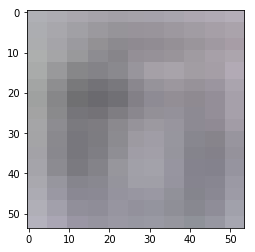

image index = 3
label = 6
prediction = 2


In [11]:
#observe misclassified sample
imgNum = idx[0]
img = images[imgNum]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(img)
plt.show()
print("image index = "+str(imgNum+1))
print("label = " + str(interpretLabel(labels[imgNum])))
print("prediction = " + str(interpretLabel(roundedScore[imgNum])))

In [12]:
#check predict length always correct
def interpretLength(label):
        return np.argmax(label[:7])

In [13]:
count = 0
for i in idx:
    if (interpretLength(labels[i]) != interpretLength(roundedScore[i])):
        count += 1
print(count)
print("length misclasification rate = "+str(count/images.shape[0]))
print(1-count/images.shape[0])

887
length misclasification rate = 0.06787572696663606
0.932124273033364


In [14]:
#index of those misclassify length
lengthidx = np.sum(np.absolute(labels[:,:7] - roundedScore[:,:7]),axis = 1)
lengthidx = np.nonzero(lengthidx)
lengthidx = lengthidx[0]
lengthidx.shape

(887,)

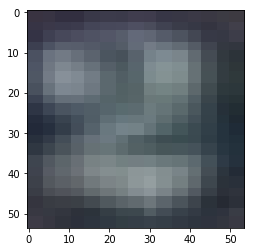

image index = 89
label = 2
prediction = 25


In [21]:
#observe misclassified length sample
imgNum = lengthidx[2]
img = images[imgNum]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(img)
plt.show()
print("image index = "+str(imgNum+1))
print("label = " + str(interpretLabel(labels[imgNum])))
print("prediction = " + str(interpretLabel(roundedScore[imgNum])))